In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    ParametersRecord,
    array_from_numpy
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "mps"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on mps
Flower 1.15.1 / PyTorch 2.6.0


In [3]:

BATCH_SIZE = 32
from flwr_datasets.partitioner import DirichletPartitioner
def load_datasets(partition_id, num_partitions: int):
    drichlet_partitioner = DirichletPartitioner(num_partitions=num_partitions, alpha=0.1, partition_by="label")
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": drichlet_partitioner})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters, trainable_layers=-1):
    """Set model parameters from a list of NumPy arrays."""
    current_state = OrderedDict(net.state_dict())
    
    if trainable_layers == -1:
        # Update all parameters
        params_dict = zip(current_state.keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)
    else:
        # Only update the specified layer's parameters
        # Convert current state to numpy arrays
        numpy_state = [param.cpu().numpy() for param in current_state.values()]
        
        # Update the specific indices with new parameters
        numpy_state[trainable_layers*2] = parameters[0]
        numpy_state[trainable_layers*2 + 1] = parameters[1]
        
        # Convert back to torch and update state dict
        for idx, key in enumerate(current_state.keys()):
            current_state[key] = torch.from_numpy(numpy_state[idx])
        
        net.load_state_dict(current_state, strict=True)


# def set_parameters(net, parameters: List[np.ndarray]):
#     params_dict = zip(net.state_dict().keys(), parameters)
#     state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
#     net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()
    net.to(DEVICE)
    previous_net.to(DEVICE)
    global_net.to(DEVICE)
    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to(DEVICE)
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
#         """Freeze specified layers of the model."""
#         for idx, (name, param) in enumerate(model.named_parameters()):
#             if idx == trainable_layers or trainable_layers == -1:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = False



def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        trainable_layers_set = []
        if trainable_layers == -1:
            trainable_layers_set = [-1]
        else:
            trainable_layers_set = [trainable_layers *2, trainable_layers *2 +1]

        for idx, (name, param) in enumerate(model.named_parameters()):
            
            if idx in trainable_layers_set or trainable_layers_set[0] == -1:
                param.requires_grad = True
                print(f"layer index is {idx} and name{name} is trainabe")
            else:
                param.requires_grad = False
                print(f"layer index is {idx} and name{name} is frozen")




In [5]:

NETWORK_LEN = len(Net().state_dict().keys()) //2 
EPOCHS = 2
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 2
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 20


In [6]:
from flwr.common import NDArrays, Scalar
import sys

# More robust evaluate function:
def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""
    
    # used to check if they're changing
    previous_params = None
    
    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        nonlocal previous_params
        
        print(f"\n==== Server-side evaluation for round {server_round} ====")
        
        # Check if parameters changed from previous round
        if previous_params is not None:
            param_change = False
            for i, (prev, curr) in enumerate(zip(previous_params, parameters)):
                diff = np.abs(prev - curr).mean()
                if diff > 1e-6:
                    param_change = True
                    print(f"  Parameter {i}: Changed by {diff:.6f}")
            
            if not param_change:
                print("  WARNING: Parameters haven't changed from previous round!")
        
        previous_params = [p.copy() for p in parameters]
        net_copy = copy.deepcopy(net)

        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v, device=DEVICE) for k, v in params_dict})
        
        # Check if state dict keys match model keys
        model_keys = set(net_copy.state_dict().keys())
        params_keys = set(state_dict.keys())
        if model_keys != params_keys:
            print(f"  WARNING: Key mismatch between model and parameters!")
            print(f"  Missing in params: {model_keys - params_keys}")
            print(f"  Extra in params: {params_keys - model_keys}")
        
        net_copy.load_state_dict(state_dict, strict=True)
        net_copy.to(DEVICE)
        net_copy.eval()
        
        # Test the model
        loss, accuracy = test(net_copy, testloader)
        print(f"  Evaluation results - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}
    
    return evaluate


def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size


# Normal FedAvg

In [7]:
from typing import Union


from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [8]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [9]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



==== Server-side evaluation for round 0 ====


INFO :      initial parameters (loss, other metrics): 0.07208652415275574, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=9212) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9212)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9212) [Client 0] fit, config: {}
(ClientAppActor pid=9207) [Client 2] fit, config: {} [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=9205) Epoch 1: train loss 0.05536116287112236, accuracy 0.3245400133008202
(ClientAppActor pid=9203) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=9212) Epoch 1: train loss 0.04521266371011734, accuracy 0.3261761158021713 [repeated 2x across cluster]
(ClientAppActor pid=9205) Epoch 2: train loss 0.045089952647686005, accuracy 0.4500110840168477
(ClientAppActor pid=9207) Epoch 1: train loss 0.028699779883027077, accuracy 0.6101118821696644
(ClientAppActor pid=9203) Epoch 1: train loss 0.0322839580476284, accuracy 0.5741485335856197 [repeated 3x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.03703894093632698, accuracy 0.4659831121833534
(ClientAppActor pid=9210) Epoch 2: train loss 0.016670065000653267, accuracy 0.8274089306698003


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 1 ====
  Parameter 0: Changed by 0.015444
  Parameter 1: Changed by 0.016248
  Parameter 2: Changed by 0.009970
  Parameter 3: Changed by 0.008180
  Parameter 4: Changed by 0.006505
  Parameter 5: Changed by 0.007257
  Parameter 6: Changed by 0.005330
  Parameter 7: Changed by 0.007279
  Parameter 8: Changed by 0.004483
  Parameter 9: Changed by 0.005254
  Parameter 10: Changed by 0.003619
  Parameter 11: Changed by 0.008570
  Parameter 12: Changed by 0.002978
  Parameter 13: Changed by 0.006187
  Parameter 14: Changed by 0.002135
  Parameter 15: Changed by 0.005991
  Parameter 16: Changed by 0.011961
  Parameter 17: Changed by 0.015757


INFO :      fit progress: (1, 0.0720986626625061, {'accuracy': 0.1}, 52.8203432909213)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=9210) [Client 2] evaluate, config: {}
(ClientAppActor pid=9203) Epoch 2: train loss 0.01883869804441929, accuracy 0.8080652790917692 [repeated 2x across cluster]


(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9205) [Client 3] fit, config: {}
(ClientAppActor pid=9207) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9205) Epoch 1: train loss 0.04661588370800018, accuracy 0.4203059188649967
(ClientAppActor pid=9203) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9207) Epoch 1: train loss 0.01993528939783573, accuracy 0.7843713278495887 [repeated 2x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.031294215470552444, accuracy 0.586565752128666 [repeated 3x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.013733387924730778, accuracy 0.8588425381903643 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 2 ====
  Parameter 0: Changed by 0.009375
  Parameter 1: Changed by 0.013591
  Parameter 2: Changed by 0.008696
  Parameter 3: Changed by 0.005693
  Parameter 4: Changed by 0.006259
  Parameter 5: Changed by 0.008136
  Parameter 6: Changed by 0.004095
  Parameter 7: Changed by 0.005265
  Parameter 8: Changed by 0.002835
  Parameter 9: Changed by 0.007736
  Parameter 10: Changed by 0.003244
  Parameter 11: Changed by 0.006943
  Parameter 12: Changed by 0.001459
  Parameter 13: Changed by 0.003395
  Parameter 14: Changed by 0.001105
  Parameter 15: Changed by 0.005368
  Parameter 16: Changed by 0.011879
  Parameter 17: Changed by 0.011211


INFO :      fit progress: (2, 0.07156204280853272, {'accuracy': 0.1286}, 102.59706045803614)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0716, Accuracy: 0.1286
(ClientAppActor pid=9207) [Client 5] evaluate, config: {}
(ClientAppActor pid=9210) Epoch 2: train loss 0.017874347046017647, accuracy 0.8187086092715232 [repeated 3x across cluster]


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9213) [Client 4] fit, config: {}
(ClientAppActor pid=9205) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9212) Epoch 1: train loss 0.018408145755529404, accuracy 0.7438423645320197
(ClientAppActor pid=9207) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.017146671190857887, accuracy 0.781617334655148 [repeated 2x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.012509397231042385, accuracy 0.8460591133004927 [repeated 4x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.012970824725925922, accuracy 0.8629553466509988 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 3 ====
  Parameter 0: Changed by 0.005602
  Parameter 1: Changed by 0.007436
  Parameter 2: Changed by 0.006490
  Parameter 3: Changed by 0.004456
  Parameter 4: Changed by 0.005256
  Parameter 5: Changed by 0.006178
  Parameter 6: Changed by 0.003946
  Parameter 7: Changed by 0.004468
  Parameter 8: Changed by 0.002366
  Parameter 9: Changed by 0.005273
  Parameter 10: Changed by 0.002280
  Parameter 11: Changed by 0.004038
  Parameter 12: Changed by 0.001219
  Parameter 13: Changed by 0.002156
  Parameter 14: Changed by 0.000839
  Parameter 15: Changed by 0.003398
  Parameter 16: Changed by 0.009942
  Parameter 17: Changed by 0.011062


INFO :      fit progress: (3, 0.06796071600914001, {'accuracy': 0.2047}, 151.08192470786162)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0680, Accuracy: 0.2047


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9213) [Client 2] evaluate, config: {}
(ClientAppActor pid=9205) Epoch 2: train loss 0.029967287555336952, accuracy 0.6044632086851629 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=9212) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9212)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9212) [Client 1] fit, config: {}
(ClientAppActor pid=9212) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9205) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=9205) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Mar  3 23:39:18 2025).
(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=9205) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9203) Epoch 1: train loss 0.03591211885213852, accuracy 0.5765905564176458
(ClientAppActor pid=9212) Epoch 1: train loss 0.0160034392029047, accuracy 0.8371034077555817 [repeated 2x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.011896749027073383, accuracy 0.8565270935960592 [repeated 4x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.011867574416100979, accuracy 0.8736780258519389 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 4 ====
  Parameter 0: Changed by 0.005077
  Parameter 1: Changed by 0.006374
  Parameter 2: Changed by 0.005149
  Parameter 3: Changed by 0.002904
  Parameter 4: Changed by 0.004511
  Parameter 5: Changed by 0.005631
  Parameter 6: Changed by 0.003604
  Parameter 7: Changed by 0.003471
  Parameter 8: Changed by 0.002018
  Parameter 9: Changed by 0.003548
  Parameter 10: Changed by 0.002117
  Parameter 11: Changed by 0.002875
  Parameter 12: Changed by 0.001101
  Parameter 13: Changed by 0.001089
  Parameter 14: Changed by 0.000718
  Parameter 15: Changed by 0.002091
  Parameter 16: Changed by 0.009610
  Parameter 17: Changed by 0.010305


INFO :      fit progress: (4, 0.06605736658573151, {'accuracy': 0.2399}, 196.90289370785467)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0661, Accuracy: 0.2399


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=9207) [Client 5] evaluate, config: {}
(ClientAppActor pid=9205) Epoch 2: train loss 0.007139282766729593, accuracy 0.9195581362413255 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9205) [Client 0] fit, config: {}
(ClientAppActor pid=9210) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]
(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=9213) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.032479215413331985, accuracy 0.6291287962757703
(ClientAppActor pid=9203) Epoch 1: train loss 0.01415751688182354, accuracy 0.8532608695652174 [repeated 2x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.00986283365637064, accuracy 0.8827996715927751 [repeated 4x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.01063704676926136, accuracy 0.8874853113983548 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 5 ====
  Parameter 0: Changed by 0.004472
  Parameter 1: Changed by 0.005737
  Parameter 2: Changed by 0.004536
  Parameter 3: Changed by 0.002535
  Parameter 4: Changed by 0.004239
  Parameter 5: Changed by 0.004511
  Parameter 6: Changed by 0.003549
  Parameter 7: Changed by 0.003203
  Parameter 8: Changed by 0.001932
  Parameter 9: Changed by 0.002731
  Parameter 10: Changed by 0.001990
  Parameter 11: Changed by 0.002237
  Parameter 12: Changed by 0.001044
  Parameter 13: Changed by 0.000960
  Parameter 14: Changed by 0.000704
  Parameter 15: Changed by 0.002180
  Parameter 16: Changed by 0.009739
  Parameter 17: Changed by 0.009924


INFO :      fit progress: (5, 0.060650117623805996, {'accuracy': 0.2955}, 244.72599316597916)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0607, Accuracy: 0.2955
(ClientAppActor pid=9205) [Client 2] evaluate, config: {}
(ClientAppActor pid=9213) Epoch 2: train loss 0.010821009986102581, accuracy 0.8908467360454115 [repeated 3x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9212) [Client 4] evaluate, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=9207) [Client 1] fit, config: {}
(ClientAppActor pid=9213) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.02928551286458969, accuracy 0.6617158058080248
(ClientAppActor pid=9212) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9207) Epoch 1: train loss 0.012910529971122742, accuracy 0.86310223266745 [repeated 2x across cluster]
(ClientAppActor pid=9213) Epoch 1: train loss 0.024864882230758667, accuracy 0.6866103739445114 [repeated 2x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.009508829563856125, accuracy 0.8961515863689776 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 6 ====
  Parameter 0: Changed by 0.003889
  Parameter 1: Changed by 0.005232
  Parameter 2: Changed by 0.004014
  Parameter 3: Changed by 0.002382
  Parameter 4: Changed by 0.003787
  Parameter 5: Changed by 0.003831
  Parameter 6: Changed by 0.003451
  Parameter 7: Changed by 0.003359
  Parameter 8: Changed by 0.002032
  Parameter 9: Changed by 0.002682
  Parameter 10: Changed by 0.002059
  Parameter 11: Changed by 0.002762
  Parameter 12: Changed by 0.001064
  Parameter 13: Changed by 0.000946
  Parameter 14: Changed by 0.000741
  Parameter 15: Changed by 0.002255
  Parameter 16: Changed by 0.009419
  Parameter 17: Changed by 0.009342


INFO :      fit progress: (6, 0.055808308851718905, {'accuracy': 0.3526}, 315.1960017080419)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0558, Accuracy: 0.3526


(ClientAppActor pid=9212) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9212)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9212) [Client 0] evaluate, config: {}
(ClientAppActor pid=9212) Epoch 2: train loss 0.009282464161515236, accuracy 0.9048013245033113 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9203) [Client 2] fit, config: {}
(ClientAppActor pid=9205) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9212) Epoch 1: train loss 0.02602010779082775, accuracy 0.7029483484814897
(ClientAppActor pid=9207) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9203) Epoch 1: train loss 0.006494720466434956, accuracy 0.9280555162158335 [repeated 2x across cluster]
(ClientAppActor pid=9210) 
(ClientAppActor pid=9212) Epoch 2: train loss 0.019465168938040733, accuracy 0.7778763023719796 [repeated 4x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.003967344760894775, accuracy 0.9582212151253363 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 7 ====
  Parameter 0: Changed by 0.003564
  Parameter 1: Changed by 0.004336
  Parameter 2: Changed by 0.003856
  Parameter 3: Changed by 0.003156
  Parameter 4: Changed by 0.003622
  Parameter 5: Changed by 0.003519
  Parameter 6: Changed by 0.003326
  Parameter 7: Changed by 0.003042
  Parameter 8: Changed by 0.002049
  Parameter 9: Changed by 0.002793
  Parameter 10: Changed by 0.002206
  Parameter 11: Changed by 0.002468
  Parameter 12: Changed by 0.001111
  Parameter 13: Changed by 0.001042
  Parameter 14: Changed by 0.000789
  Parameter 15: Changed by 0.002109
  Parameter 16: Changed by 0.010261
  Parameter 17: Changed by 0.009375


INFO :      fit progress: (7, 0.05190585736036301, {'accuracy': 0.4025}, 363.81768866605125)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0519, Accuracy: 0.4025


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9210) [Client 0] evaluate, config: {}
(ClientAppActor pid=9210) Epoch 2: train loss 0.007917038165032864, accuracy 0.9191106906338694 [repeated 3x across cluster]
(ClientAppActor pid=9207) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9213) [Client 1] fit, config: {}
(ClientAppActor pid=9213) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]
(ClientAppActor pid=9212) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=9212)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=9212) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9203) Epoch 1: train loss 0.024113675579428673, accuracy 0.7215694967856351
(ClientAppActor pid=9213) Epoch 1: train loss 0.010724548250436783, accuracy 0.8889541715628673 [repeated 2x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.017710687592625618, accuracy 0.7969408113500333 [repeated 3x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.007468959782272577, accuracy 0.9187720329024677 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 8 ====
  Parameter 0: Changed by 0.003305
  Parameter 1: Changed by 0.005049
  Parameter 2: Changed by 0.003460
  Parameter 3: Changed by 0.001946
  Parameter 4: Changed by 0.003444
  Parameter 5: Changed by 0.003613
  Parameter 6: Changed by 0.003239
  Parameter 7: Changed by 0.002570
  Parameter 8: Changed by 0.002016
  Parameter 9: Changed by 0.002782
  Parameter 10: Changed by 0.002230
  Parameter 11: Changed by 0.002433
  Parameter 12: Changed by 0.001101
  Parameter 13: Changed by 0.001056
  Parameter 14: Changed by 0.000826
  Parameter 15: Changed by 0.002152
  Parameter 16: Changed by 0.009880
  Parameter 17: Changed by 0.008686


INFO :      fit progress: (8, 0.04847889552116394, {'accuracy': 0.4423}, 411.8281384999864)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0485, Accuracy: 0.4423
(ClientAppActor pid=9210) [Client 5] evaluate, config: {}
(ClientAppActor pid=9207) Epoch 2: train loss 0.006564008537679911, accuracy 0.9315279091769157 [repeated 3x across cluster]


(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9203) [Client 4] fit, config: {}
(ClientAppActor pid=9212) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=9205) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.00847156997770071, accuracy 0.9002463054187192
(ClientAppActor pid=9203) Epoch 1: train loss 0.008553462103009224, accuracy 0.9111873226111636 [repeated 3x across cluster]
(ClientAppActor pid=9210) Epoch 2: train loss 0.005177841987460852, accuracy 0.9419129720853858 [repeated 2x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.006825301796197891, accuracy 0.9228848413631022 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=9205) Epoch 2: train loss 0.003317984053865075, accuracy 0.9634612661096162 [repeated 3x across cluster]

==== Server-side evaluation for round 9 ====
  Parameter 0: Changed by 0.003081
  Parameter 1: Changed by 0.003667
  Parameter 2: Changed by 0.003320
  Parameter 3: Changed by 0.002214
  Parameter 4: Changed by 0.003381
  Parameter 5: Changed by 0.003244
  Parameter 6: Changed by 0.003273
  Parameter 7: Changed by 0.002805
  Parameter 8: Changed by 0.002084
  Parameter 9: Changed by 0.002793
  Parameter 10: Changed by 0.002251
  Parameter 11: Changed by 0.002573
  Parameter 12: Changed by 0.001201
  Parameter 13: Changed by 0.001075
  Parameter 14: Changed by 0.000939
  Parameter 15: Changed by 0.002092
  Parameter 16: Changed by 0.010962
  Parameter 17: Changed by 0.009281


INFO :      fit progress: (9, 0.04535672659277916, {'accuracy': 0.4808}, 466.8052846249193)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0454, Accuracy: 0.4808


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9205) [Client 0] evaluate, config: {}


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9212) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9205) [Client 0] fit, config: {}


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=9207) Epoch 1: train loss 0.020538128912448883, accuracy 0.7712258922633562
(ClientAppActor pid=9210) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9212) Epoch 1: train loss 0.009310094639658928, accuracy 0.9024676850763808 [repeated 2x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.005282304715365171, accuracy 0.9382183908045977 [repeated 4x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.006089860573410988, accuracy 0.9337544065804936 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 10 ====
  Parameter 0: Changed by 0.003247
  Parameter 1: Changed by 0.003984
  Parameter 2: Changed by 0.003159
  Parameter 3: Changed by 0.001892
  Parameter 4: Changed by 0.003335
  Parameter 5: Changed by 0.003197
  Parameter 6: Changed by 0.003242
  Parameter 7: Changed by 0.002931
  Parameter 8: Changed by 0.002049
  Parameter 9: Changed by 0.002514
  Parameter 10: Changed by 0.002303
  Parameter 11: Changed by 0.002526
  Parameter 12: Changed by 0.001239
  Parameter 13: Changed by 0.001199
  Parameter 14: Changed by 0.000963
  Parameter 15: Changed by 0.002209
  Parameter 16: Changed by 0.011022
  Parameter 17: Changed by 0.009552


INFO :      fit progress: (10, 0.04320256834030151, {'accuracy': 0.5139}, 522.6180218330119)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0432, Accuracy: 0.5139
(ClientAppActor pid=9205) [Client 0] evaluate, config: {}
(ClientAppActor pid=9210) Epoch 2: train loss 0.004878577776253223, accuracy 0.950212866603595 [repeated 3x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9207) [Client 0] fit, config: {}


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=9210) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9205) Epoch 1: train loss 0.006964871659874916, accuracy 0.9205665024630542
(ClientAppActor pid=9203) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9213) Epoch 1: train loss 0.008625837974250317, accuracy 0.9086368977673326 [repeated 2x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.012337854132056236, accuracy 0.8590113056971846 [repeated 4x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.005221041850745678, accuracy 0.9447708578143361 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 11 ====
  Parameter 0: Changed by 0.002840
  Parameter 1: Changed by 0.003547
  Parameter 2: Changed by 0.003140
  Parameter 3: Changed by 0.002513
  Parameter 4: Changed by 0.003269
  Parameter 5: Changed by 0.002969
  Parameter 6: Changed by 0.003154
  Parameter 7: Changed by 0.002878
  Parameter 8: Changed by 0.002053
  Parameter 9: Changed by 0.002585
  Parameter 10: Changed by 0.002309
  Parameter 11: Changed by 0.002988
  Parameter 12: Changed by 0.001240
  Parameter 13: Changed by 0.001174
  Parameter 14: Changed by 0.000972
  Parameter 15: Changed by 0.002025
  Parameter 16: Changed by 0.011602
  Parameter 17: Changed by 0.009593


INFO :      fit progress: (11, 0.040108791768550874, {'accuracy': 0.5379}, 571.8944768749643)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0401, Accuracy: 0.5379
(ClientAppActor pid=9203) [Client 4] evaluate, config: {}
(ClientAppActor pid=9210) Epoch 2: train loss 0.004497227258980274, accuracy 0.9532876064333018 [repeated 3x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9212) [Client 3] fit, config: {}
(ClientAppActor pid=9207) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=9212) Epoch 1: train loss 0.01737096905708313, accuracy 0.8084681888716471
(ClientAppActor pid=9210) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9207) Epoch 1: train loss 0.008316566236317158, accuracy 0.9068742655699178 [repeated 2x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.003909076098352671, accuracy 0.9542282430213465 [repeated 5x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.0045991819351911545, accuracy 0.9521151586368978
(ClientAppActor pid=9210) Epoch 2: train loss 0.001862435368821025, accuracy 0.978331681065005


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 12 ====
  Parameter 0: Changed by 0.002811
  Parameter 1: Changed by 0.002885
  Parameter 2: Changed by 0.003001
  Parameter 3: Changed by 0.001983
  Parameter 4: Changed by 0.003087
  Parameter 5: Changed by 0.002779
  Parameter 6: Changed by 0.002969
  Parameter 7: Changed by 0.002694
  Parameter 8: Changed by 0.002037
  Parameter 9: Changed by 0.002794
  Parameter 10: Changed by 0.002337
  Parameter 11: Changed by 0.002813
  Parameter 12: Changed by 0.001269
  Parameter 13: Changed by 0.001463
  Parameter 14: Changed by 0.001045
  Parameter 15: Changed by 0.002077
  Parameter 16: Changed by 0.011792
  Parameter 17: Changed by 0.009631


INFO :      fit progress: (12, 0.04071872134804726, {'accuracy': 0.5476}, 619.20609087497)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0407, Accuracy: 0.5476
(ClientAppActor pid=9207) [Client 2] evaluate, config: {}
(ClientAppActor pid=9205) Epoch 2: train loss 0.004010292701423168, accuracy 0.9575449385052034 [repeated 2x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9210) [Client 0] fit, config: {}
(ClientAppActor pid=9213) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9203) Epoch 1: train loss 0.01566259376704693, accuracy 0.8259809354910219
(ClientAppActor pid=9213) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9207) Epoch 1: train loss 0.00339890131726861, accuracy 0.9638861351083416 [repeated 2x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.003083890536800027, accuracy 0.9638752052545156 [repeated 5x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.003861780045554042, accuracy 0.9584312573443008
(ClientAppActor pid=9207) Epoch 2: train loss 0.0017961433622986078, accuracy 0.9814473870556578


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 13 ====
  Parameter 0: Changed by 0.002878
  Parameter 1: Changed by 0.003088
  Parameter 2: Changed by 0.002896
  Parameter 3: Changed by 0.002003
  Parameter 4: Changed by 0.003047
  Parameter 5: Changed by 0.003012
  Parameter 6: Changed by 0.003092
  Parameter 7: Changed by 0.002176
  Parameter 8: Changed by 0.002190
  Parameter 9: Changed by 0.002736
  Parameter 10: Changed by 0.002406
  Parameter 11: Changed by 0.003169
  Parameter 12: Changed by 0.001303
  Parameter 13: Changed by 0.001477
  Parameter 14: Changed by 0.001038
  Parameter 15: Changed by 0.002494
  Parameter 16: Changed by 0.011474
  Parameter 17: Changed by 0.009372


INFO :      fit progress: (13, 0.03883767837285995, {'accuracy': 0.561}, 666.8542042910121)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0388, Accuracy: 0.5610


(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9210) [Client 4] evaluate, config: {}
(ClientAppActor pid=9205) Epoch 2: train loss 0.003410263219848275, accuracy 0.9640491958372753 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9203) [Client 1] fit, config: {}
(ClientAppActor pid=9207) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=9207) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9205) Epoch 1: train loss 0.006390375550836325, accuracy 0.9275451559934319
(ClientAppActor pid=9210) Epoch 1: train loss 0.004831261467188597, accuracy 0.9495033112582781 [repeated 3x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.0036469746846705675, accuracy 0.9593125734430082 [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 2: train loss 0.003176626516506076, accuracy 0.967360454115421
(ClientAppActor pid=9207) Epoch 2: train loss 0.0017096928786486387, accuracy 0.9817306330548081


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 14 ====
  Parameter 0: Changed by 0.002973
  Parameter 1: Changed by 0.004073
  Parameter 2: Changed by 0.003002
  Parameter 3: Changed by 0.002064
  Parameter 4: Changed by 0.003016
  Parameter 5: Changed by 0.003116
  Parameter 6: Changed by 0.003066
  Parameter 7: Changed by 0.002706
  Parameter 8: Changed by 0.002209
  Parameter 9: Changed by 0.003283
  Parameter 10: Changed by 0.002486
  Parameter 11: Changed by 0.003220
  Parameter 12: Changed by 0.001291
  Parameter 13: Changed by 0.001637
  Parameter 14: Changed by 0.001048
  Parameter 15: Changed by 0.002338
  Parameter 16: Changed by 0.011766
  Parameter 17: Changed by 0.008824


INFO :      fit progress: (14, 0.03731363770365715, {'accuracy': 0.5751}, 718.3867386248894)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0373, Accuracy: 0.5751


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9207) [Client 4] evaluate, config: {}
(ClientAppActor pid=9212) Epoch 2: train loss 0.006460342090576887, accuracy 0.9249698431845597


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9205) [Client 3] fit, config: {}
(ClientAppActor pid=9210) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=9205) Epoch 1: train loss 0.014392887242138386, accuracy 0.8390600753713146
(ClientAppActor pid=9210) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9212) Epoch 1: train loss 0.002876738552004099, accuracy 0.9712505310862484 [repeated 2x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.002517384011298418, accuracy 0.9700328407224958 [repeated 5x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.001521529396995902, accuracy 0.9845630930463107
(ClientAppActor pid=9210) Epoch 2: train loss 0.00365867605432868, accuracy 0.9612220916568742


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 15 ====
  Parameter 0: Changed by 0.002823
  Parameter 1: Changed by 0.003769
  Parameter 2: Changed by 0.002874
  Parameter 3: Changed by 0.001786
  Parameter 4: Changed by 0.003029
  Parameter 5: Changed by 0.002491
  Parameter 6: Changed by 0.003218
  Parameter 7: Changed by 0.002494
  Parameter 8: Changed by 0.002369
  Parameter 9: Changed by 0.002967
  Parameter 10: Changed by 0.002503
  Parameter 11: Changed by 0.003221
  Parameter 12: Changed by 0.001239
  Parameter 13: Changed by 0.001674
  Parameter 14: Changed by 0.001100
  Parameter 15: Changed by 0.002454
  Parameter 16: Changed by 0.011147
  Parameter 17: Changed by 0.007360


INFO :      fit progress: (15, 0.0369933803498745, {'accuracy': 0.5859}, 770.067880165996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0370, Accuracy: 0.5859
(ClientAppActor pid=9205) [Client 3] evaluate, config: {}
(ClientAppActor pid=9207) Epoch 2: train loss 0.002675452269613743, accuracy 0.9722090823084201 [repeated 2x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9207) [Client 3] fit, config: {}
(ClientAppActor pid=9212) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=9207) Epoch 1: train loss 0.013712652958929539, accuracy 0.8465972068277544
(ClientAppActor pid=9213) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.005658207461237907, accuracy 0.9388954171562868 [repeated 2x across cluster]
(ClientAppActor pid=9207) Epoch 2: train loss 0.00666457274928689, accuracy 0.9252937264464642 [repeated 3x across cluster]
(ClientAppActor pid=9210) Epoch 2: train loss 0.0032396032474935055, accuracy 0.9650411280846063 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 16 ====
  Parameter 0: Changed by 0.002670
  Parameter 1: Changed by 0.003560
  Parameter 2: Changed by 0.002793
  Parameter 3: Changed by 0.001748
  Parameter 4: Changed by 0.002960
  Parameter 5: Changed by 0.002753
  Parameter 6: Changed by 0.003203
  Parameter 7: Changed by 0.002641
  Parameter 8: Changed by 0.002420
  Parameter 9: Changed by 0.003535
  Parameter 10: Changed by 0.002504
  Parameter 11: Changed by 0.003495
  Parameter 12: Changed by 0.001269
  Parameter 13: Changed by 0.001736
  Parameter 14: Changed by 0.001105
  Parameter 15: Changed by 0.002170
  Parameter 16: Changed by 0.012288
  Parameter 17: Changed by 0.008580


INFO :      fit progress: (16, 0.0360658985376358, {'accuracy': 0.5923}, 821.3138067498803)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0361, Accuracy: 0.5923


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=9210) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=9210)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=9213) [Client 0] evaluate, config: {}
(ClientAppActor pid=9213) Epoch 2: train loss 0.0026814043521881104, accuracy 0.9735099337748344 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9207) [Client 0] fit, config: {}
(ClientAppActor pid=9207) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=9212) Epoch 1: train loss 0.004820608533918858, accuracy 0.9499178981937603
(ClientAppActor pid=9205) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9203) Epoch 1: train loss 0.004985172301530838, accuracy 0.9481492361927144 [repeated 2x across cluster]
(ClientAppActor pid=9210) Epoch 2: train loss 0.006018661893904209, accuracy 0.9330525382398581 [repeated 4x across cluster]
(ClientAppActor pid=9203) Epoch 2: train loss 0.0026982950512319803, accuracy 0.9694477085781433 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 17 ====
  Parameter 0: Changed by 0.002683
  Parameter 1: Changed by 0.002998
  Parameter 2: Changed by 0.002934
  Parameter 3: Changed by 0.001499
  Parameter 4: Changed by 0.003108
  Parameter 5: Changed by 0.002811
  Parameter 6: Changed by 0.003260
  Parameter 7: Changed by 0.002558
  Parameter 8: Changed by 0.002435
  Parameter 9: Changed by 0.003246
  Parameter 10: Changed by 0.002602
  Parameter 11: Changed by 0.003106
  Parameter 12: Changed by 0.001305
  Parameter 13: Changed by 0.001811
  Parameter 14: Changed by 0.001113
  Parameter 15: Changed by 0.002660
  Parameter 16: Changed by 0.012785
  Parameter 17: Changed by 0.008604


INFO :      fit progress: (17, 0.03669869746565819, {'accuracy': 0.5933}, 870.5701945000328)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0367, Accuracy: 0.5933


(ClientAppActor pid=9212) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9212)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9205) [Client 4] evaluate, config: {}
(ClientAppActor pid=9213) Epoch 2: train loss 0.0027170758694410324, accuracy 0.9711447492904447 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9205) [Client 1] fit, config: {}
(ClientAppActor pid=9213) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9210) Epoch 1: train loss 0.011882374063134193, accuracy 0.8658833961427621
(ClientAppActor pid=9207) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9205) Epoch 1: train loss 0.004654193762689829, accuracy 0.9499118683901293 [repeated 2x across cluster]
(ClientAppActor pid=9212) Epoch 1: train loss 0.003710065269842744, accuracy 0.9621570482497634 [repeated 2x across cluster]
(ClientAppActor pid=9205) Epoch 2: train loss 0.00224938802421093, accuracy 0.9751762632197415 [repeated 4x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.002822806825861335, accuracy 0.9692526017029328 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 18 ====
  Parameter 0: Changed by 0.002763
  Parameter 1: Changed by 0.003696
  Parameter 2: Changed by 0.002937
  Parameter 3: Changed by 0.001936
  Parameter 4: Changed by 0.003055
  Parameter 5: Changed by 0.003215
  Parameter 6: Changed by 0.003204
  Parameter 7: Changed by 0.002461
  Parameter 8: Changed by 0.002472
  Parameter 9: Changed by 0.003298
  Parameter 10: Changed by 0.002610
  Parameter 11: Changed by 0.003279
  Parameter 12: Changed by 0.001266
  Parameter 13: Changed by 0.001803
  Parameter 14: Changed by 0.001108
  Parameter 15: Changed by 0.002661
  Parameter 16: Changed by 0.011392
  Parameter 17: Changed by 0.008298


INFO :      fit progress: (18, 0.03627659576535225, {'accuracy': 0.6039}, 926.6111120830756)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0363, Accuracy: 0.6039
(ClientAppActor pid=9203) [Client 5] evaluate, config: {}
(ClientAppActor pid=9207) Epoch 2: train loss 0.0038983793929219246, accuracy 0.9558504221954162


(ClientAppActor pid=9203) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9203)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9207) [Client 0] fit, config: {}
(ClientAppActor pid=9207) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9207) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9207)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=9212) Epoch 1: train loss 0.01109823863953352, accuracy 0.8747506096209267
(ClientAppActor pid=9203) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9210) Epoch 1: train loss 0.004028351046144962, accuracy 0.956668625146886 [repeated 2x across cluster]
(ClientAppActor pid=9212) Epoch 2: train loss 0.005811275448650122, accuracy 0.9337175792507204 [repeated 4x across cluster]
(ClientAppActor pid=9210) Epoch 2: train loss 0.002281873021274805, accuracy 0.9751762632197415 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 19 ====
  Parameter 0: Changed by 0.002591
  Parameter 1: Changed by 0.003364
  Parameter 2: Changed by 0.003030
  Parameter 3: Changed by 0.001700
  Parameter 4: Changed by 0.003051
  Parameter 5: Changed by 0.003073
  Parameter 6: Changed by 0.003079
  Parameter 7: Changed by 0.002332
  Parameter 8: Changed by 0.002453
  Parameter 9: Changed by 0.004038
  Parameter 10: Changed by 0.002690
  Parameter 11: Changed by 0.004063
  Parameter 12: Changed by 0.001266
  Parameter 13: Changed by 0.001909
  Parameter 14: Changed by 0.001130
  Parameter 15: Changed by 0.002732
  Parameter 16: Changed by 0.012109
  Parameter 17: Changed by 0.008718


INFO :      fit progress: (19, 0.035057984107732774, {'accuracy': 0.6066}, 980.4109611660242)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0351, Accuracy: 0.6066
(ClientAppActor pid=9207) [Client 5] evaluate, config: {}
(ClientAppActor pid=9213) Epoch 2: train loss 0.0021213130094110966, accuracy 0.9784768211920529 [repeated 3x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=9210) [Client 4] fit, config: {}
(ClientAppActor pid=9213) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=9205) Epoch 1: train loss 0.010900993831455708, accuracy 0.8800709377078253
(ClientAppActor pid=9213) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=9203) Epoch 1: train loss 0.002203485229983926, accuracy 0.977340320067979 [repeated 2x across cluster]
(ClientAppActor pid=9205) Epoch 2: train loss 0.004667404107749462, accuracy 0.9490135225005542 [repeated 4x across cluster]
(ClientAppActor pid=9213) Epoch 2: train loss 0.002890093717724085, accuracy 0.9698883666274971 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 20 ====
  Parameter 0: Changed by 0.004070
  Parameter 1: Changed by 0.004573
  Parameter 2: Changed by 0.003226
  Parameter 3: Changed by 0.002157
  Parameter 4: Changed by 0.003198
  Parameter 5: Changed by 0.003712
  Parameter 6: Changed by 0.003342
  Parameter 7: Changed by 0.003887
  Parameter 8: Changed by 0.002676
  Parameter 9: Changed by 0.005253
  Parameter 10: Changed by 0.002749
  Parameter 11: Changed by 0.004211
  Parameter 12: Changed by 0.001279
  Parameter 13: Changed by 0.002002
  Parameter 14: Changed by 0.001268
  Parameter 15: Changed by 0.002821
  Parameter 16: Changed by 0.011928
  Parameter 17: Changed by 0.007713


INFO :      fit progress: (20, 0.03457482828497887, {'accuracy': 0.6089}, 1031.5914890409913)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0346, Accuracy: 0.6089
(ClientAppActor pid=9207) [Client 0] evaluate, config: {}
(ClientAppActor pid=9210) Epoch 2: train loss 0.002632675925269723, accuracy 0.9756385998107853 [repeated 3x across cluster]


(ClientAppActor pid=9205) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=9205)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 1036.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07301064834962571
INFO :      		round 2: 0.07243431249918483
INFO :      		round 3: 0.0687902769968253
INFO :      		round 4: 0.06696861062054962
INFO :      		round 5: 0.06159440954965113
INFO :      		round 6: 0.056671848136163216
INFO :      		round 7: 0.05255681032441983
INFO :      		round 8: 0.04915200407585614
INFO :      		round 9: 0.04588036986856672
INFO :      		round 10: 0.04360327588360288
INFO :      		round 11: 0.04047312

(ClientAppActor pid=9213) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9213) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=9213)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:

 
with open(f'results/fed_avg_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_avg_result, file)

with open(f'results/fed_avg_model_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_avg_model_results, file)

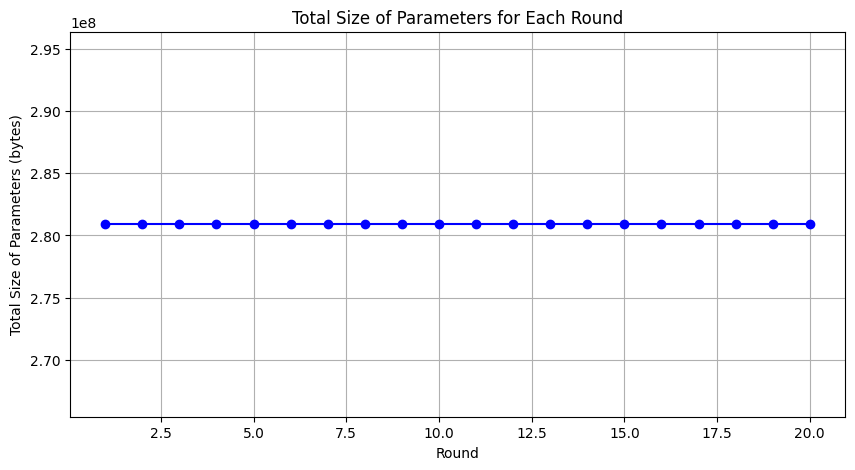

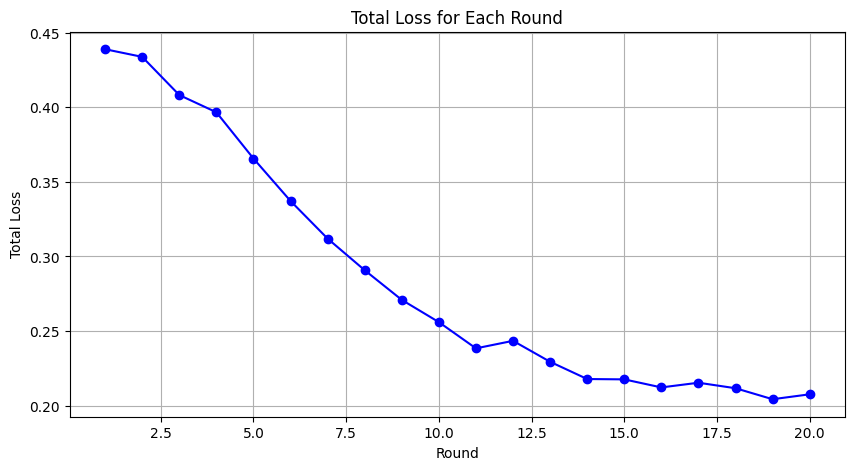

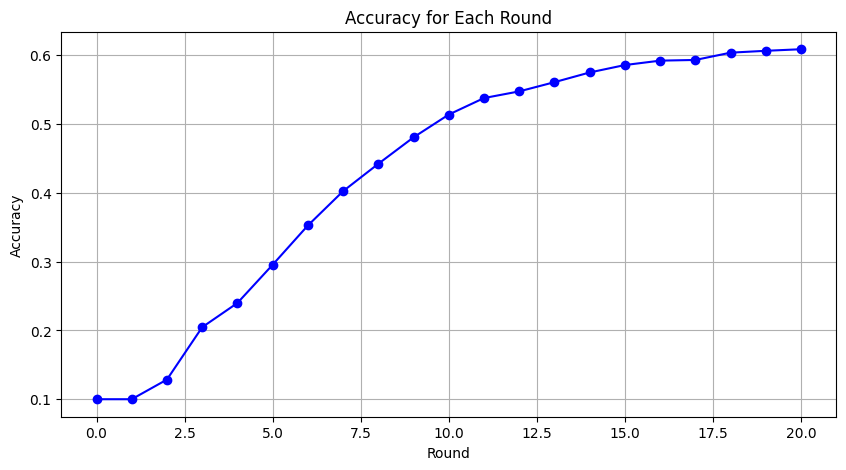

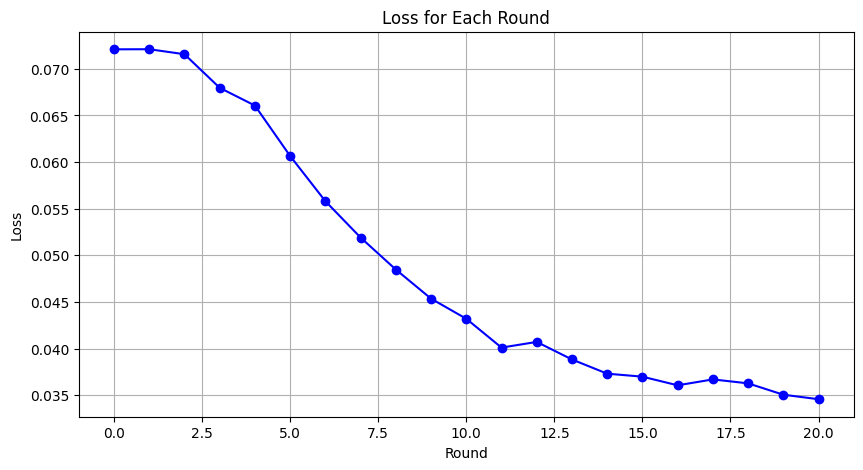

In [11]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedProx experiments:

In [12]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [13]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [14]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



==== Server-side evaluation for round 0 ====


INFO :      initial parameters (loss, other metrics): 0.0720759373664856, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=39925) [Client 4] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39924) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.021008098497986794, accuracy 0.6863711001642037
(ClientAppActor pid=39927) Epoch 1: train loss 0.029616734012961388, accuracy 0.5606639247943596
(ClientAppActor pid=39928) Epoch 1: train loss 0.044535066932439804, accuracy 0.3278648974668275
(ClientAppActor pid=39923) Epoch 2: train loss 0.013555324636399746, accuracy 0.8325123152709359 [repeated 4x across cluster]
(ClientAppActor pid=39924) Epoch 2: train loss 0.04688896983861923, accuracy 0.4140988694302815
(ClientAppActor pid=39927) Epoch 2: train loss 0.016644349321722984, accuracy 0.8222679200940071


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 1 ====
  Parameter 0: Changed by 0.012659
  Parameter 1: Changed by 0.014448
  Parameter 2: Changed by 0.010300
  Parameter 3: Changed by 0.009978
  Parameter 4: Changed by 0.006558
  Parameter 5: Changed by 0.009181
  Parameter 6: Changed by 0.005273
  Parameter 7: Changed by 0.008215
  Parameter 8: Changed by 0.004307
  Parameter 9: Changed by 0.006456
  Parameter 10: Changed by 0.004170
  Parameter 11: Changed by 0.010846
  Parameter 12: Changed by 0.003145
  Parameter 13: Changed by 0.007401
  Parameter 14: Changed by 0.002280
  Parameter 15: Changed by 0.007378
  Parameter 16: Changed by 0.013637
  Parameter 17: Changed by 0.017293


INFO :      fit progress: (1, 0.07209616749286651, {'accuracy': 0.1}, 59.9354448330123)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=39927) [Client 1] evaluate, config: {}
(ClientAppActor pid=39925) Epoch 2: train loss 0.020635761320590973, accuracy 0.788434247871334 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39925) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39926) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39926) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=39926)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=39924) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.021631406620144844, accuracy 0.7050492610837439
(ClientAppActor pid=39925) Epoch 1: train loss 0.02993842028081417, accuracy 0.5611045828437132 [repeated 2x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.042573921382427216, accuracy 0.3661037394451146 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.013479132205247879, accuracy 0.8273809523809523 [repeated 2x across cluster]
(ClientAppActor pid=39925) Epoch 2: train loss 0.019236186519265175, accuracy 0.7809929494712103 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=39924) Epoch 2: train loss 0.018279792740941048, accuracy 0.8133869441816461 [repeated 3x across cluster]
total size: 280903200

==== Server-side evaluation for round 2 ====
  Parameter 0: Changed by 0.008200
  Parameter 1: Changed by 0.009861
  Parameter 2: Changed by 0.009447
  Parameter 3: Changed by 0.006436
  Parameter 4: Changed by 0.005687
  Parameter 5: Changed by 0.007744
  Parameter 6: Changed by 0.003063
  Parameter 7: Changed by 0.005257
  Parameter 8: Changed by 0.002060
  Parameter 9: Changed by 0.009461
  Parameter 10: Changed by 0.002404
  Parameter 11: Changed by 0.005810
  Parameter 12: Changed by 0.001072
  Parameter 13: Changed by 0.002802
  Parameter 14: Changed by 0.000804
  Parameter 15: Changed by 0.005467
  Parameter 16: Changed by 0.012161
  Parameter 17: Changed by 0.012477


INFO :      fit progress: (2, 0.07292312395572663, {'accuracy': 0.1}, 119.73884800006635)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0729, Accuracy: 0.1000


(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=39924) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39928) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39925) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.04465338587760925, accuracy 0.4739525604078918
(ClientAppActor pid=39923) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.02940378338098526, accuracy 0.5680082256169212 [repeated 2x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.038101788610219955, accuracy 0.4536791314837153 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.027691371738910675, accuracy 0.5850470035252644 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 3 ====
  Parameter 0: Changed by 0.006258
  Parameter 1: Changed by 0.007688
  Parameter 2: Changed by 0.007268
  Parameter 3: Changed by 0.003896
  Parameter 4: Changed by 0.005561
  Parameter 5: Changed by 0.006968
  Parameter 6: Changed by 0.002779
  Parameter 7: Changed by 0.003926
  Parameter 8: Changed by 0.001237
  Parameter 9: Changed by 0.005416
  Parameter 10: Changed by 0.002057
  Parameter 11: Changed by 0.005330
  Parameter 12: Changed by 0.000988
  Parameter 13: Changed by 0.001490
  Parameter 14: Changed by 0.000612
  Parameter 15: Changed by 0.003466
  Parameter 16: Changed by 0.011130
  Parameter 17: Changed by 0.010592


INFO :      fit progress: (3, 0.07273651785850525, {'accuracy': 0.1}, 176.47960912506096)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0727, Accuracy: 0.1000
(ClientAppActor pid=39923) [Client 4] evaluate, config: {}
(ClientAppActor pid=39923) Epoch 2: train loss 0.015016590245068073, accuracy 0.8470908230842006 [repeated 3x across cluster]


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39927) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.037830181419849396, accuracy 0.5630680558634449
(ClientAppActor pid=39923) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.017271265387535095, accuracy 0.8174206815511164 [repeated 2x across cluster]
(ClientAppActor pid=39928) Epoch 2: train loss 0.030789202079176903, accuracy 0.6426512968299711 [repeated 4x across cluster]
(ClientAppActor pid=39925) Epoch 2: train loss 0.013131516985595226, accuracy 0.8629553466509988 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 4 ====
  Parameter 0: Changed by 0.004948
  Parameter 1: Changed by 0.007888
  Parameter 2: Changed by 0.006585
  Parameter 3: Changed by 0.004046
  Parameter 4: Changed by 0.005686
  Parameter 5: Changed by 0.006596
  Parameter 6: Changed by 0.002895
  Parameter 7: Changed by 0.003540
  Parameter 8: Changed by 0.001412
  Parameter 9: Changed by 0.005551
  Parameter 10: Changed by 0.002207
  Parameter 11: Changed by 0.003707
  Parameter 12: Changed by 0.000878
  Parameter 13: Changed by 0.000881
  Parameter 14: Changed by 0.000561
  Parameter 15: Changed by 0.002381
  Parameter 16: Changed by 0.011042
  Parameter 17: Changed by 0.010375


INFO :      fit progress: (4, 0.06774346290826798, {'accuracy': 0.2254}, 230.8701498331502)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0677, Accuracy: 0.2254


(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39924) [Client 3] evaluate, config: {}
(ClientAppActor pid=39926) Epoch 2: train loss 0.027466081082820892, accuracy 0.6466827503015682 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39923) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39926) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39926)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39926) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.0328136570751667, accuracy 0.6162713367324318
(ClientAppActor pid=39928) Epoch 1: train loss 0.014734371565282345, accuracy 0.847972972972973 [repeated 2x across cluster]
(ClientAppActor pid=39925) Epoch 2: train loss 0.02743550017476082, accuracy 0.6756816670361339 [repeated 3x across cluster]
(ClientAppActor pid=39928) Epoch 2: train loss 0.011125396937131882, accuracy 0.8823443008225617 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 5 ====
  Parameter 0: Changed by 0.004562
  Parameter 1: Changed by 0.006831
  Parameter 2: Changed by 0.005883
  Parameter 3: Changed by 0.003763
  Parameter 4: Changed by 0.005134
  Parameter 5: Changed by 0.005380
  Parameter 6: Changed by 0.002642
  Parameter 7: Changed by 0.003069
  Parameter 8: Changed by 0.001221
  Parameter 9: Changed by 0.002980
  Parameter 10: Changed by 0.001844
  Parameter 11: Changed by 0.002534
  Parameter 12: Changed by 0.000827
  Parameter 13: Changed by 0.000680
  Parameter 14: Changed by 0.000570
  Parameter 15: Changed by 0.002199
  Parameter 16: Changed by 0.010697
  Parameter 17: Changed by 0.010380


INFO :      fit progress: (5, 0.06245301984548569, {'accuracy': 0.2805}, 285.5517098749988)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0625, Accuracy: 0.2805


(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=39924) [Client 4] evaluate, config: {}
(ClientAppActor pid=39926) Epoch 2: train loss 0.010613242164254189, accuracy 0.891438032166509 [repeated 3x across cluster]


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39924) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.029687119647860527, accuracy 0.6528485923298604
(ClientAppActor pid=39926) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.007914603687822819, accuracy 0.9109191332672426 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.024012744426727295, accuracy 0.719352693416094 [repeated 4x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.0101061025634408, accuracy 0.8924794359576969 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 6 ====
  Parameter 0: Changed by 0.004240
  Parameter 1: Changed by 0.006343
  Parameter 2: Changed by 0.005202
  Parameter 3: Changed by 0.003111
  Parameter 4: Changed by 0.004751
  Parameter 5: Changed by 0.004429
  Parameter 6: Changed by 0.002684
  Parameter 7: Changed by 0.003192
  Parameter 8: Changed by 0.001259
  Parameter 9: Changed by 0.002392
  Parameter 10: Changed by 0.001743
  Parameter 11: Changed by 0.002435
  Parameter 12: Changed by 0.000829
  Parameter 13: Changed by 0.000660
  Parameter 14: Changed by 0.000578
  Parameter 15: Changed by 0.002260
  Parameter 16: Changed by 0.010726
  Parameter 17: Changed by 0.009626


INFO :      fit progress: (6, 0.05850054512023926, {'accuracy': 0.3209}, 342.9535122080706)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0585, Accuracy: 0.3209
(ClientAppActor pid=39925) [Client 1] evaluate, config: {}
(ClientAppActor pid=39925) 
(ClientAppActor pid=39928) Epoch 2: train loss 0.009182817302644253, accuracy 0.9037369914853358 [repeated 3x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39928) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.02691802754998207, accuracy 0.683662159166482
(ClientAppActor pid=39927) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.0065788691863417625, accuracy 0.9280555162158335 [repeated 2x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.02044077403843403, accuracy 0.7619153181112835 [repeated 4x across cluster]
(ClientAppActor pid=39926) Epoch 2: train loss 0.009027370251715183, accuracy 0.9036427732079906 [repeated 2x across cluster]
(ClientAppActor pid=39925) 
(ClientAppActor pid=39925) Epoch 2: train loss 0.018865739926695824, accuracy 0.7694813027744271 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 7 ====
  Parameter 0: Changed by 0.003327
  Parameter 1: Changed by 0.004413
  Parameter 2: Changed by 0.004936
  Parameter 3: Changed by 0.002620
  Parameter 4: Changed by 0.004501
  Parameter 5: Changed by 0.003509
  Parameter 6: Changed by 0.002497
  Parameter 7: Changed by 0.003098
  Parameter 8: Changed by 0.001391
  Parameter 9: Changed by 0.003113
  Parameter 10: Changed by 0.001991
  Parameter 11: Changed by 0.002152
  Parameter 12: Changed by 0.000824
  Parameter 13: Changed by 0.000623
  Parameter 14: Changed by 0.000620
  Parameter 15: Changed by 0.002065
  Parameter 16: Changed by 0.011310
  Parameter 17: Changed by 0.009729


INFO :      fit progress: (7, 0.05345531913042068, {'accuracy': 0.3827}, 402.513971083099)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0535, Accuracy: 0.3827
(ClientAppActor pid=39925) [Client 3] evaluate, config: {}
(ClientAppActor pid=39927) Epoch 2: train loss 0.007661572191864252, accuracy 0.9228949858088931


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39925) [Client 5] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=39924) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.010008343495428562, accuracy 0.8860837438423645
(ClientAppActor pid=39923) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.01130514033138752, accuracy 0.8811692126909518 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.01827998273074627, accuracy 0.7878519175349147 [repeated 2x across cluster]
(ClientAppActor pid=39924) Epoch 2: train loss 0.007681815419346094, accuracy 0.9165687426556992 [repeated 4x across cluster]
(ClientAppActor pid=39928) Epoch 2: train loss 0.01718258671462536, accuracy 0.793848009650181 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 8 ====
  Parameter 0: Changed by 0.003287
  Parameter 1: Changed by 0.002999
  Parameter 2: Changed by 0.004505
  Parameter 3: Changed by 0.002756
  Parameter 4: Changed by 0.004175
  Parameter 5: Changed by 0.003210
  Parameter 6: Changed by 0.002458
  Parameter 7: Changed by 0.002566
  Parameter 8: Changed by 0.001348
  Parameter 9: Changed by 0.003001
  Parameter 10: Changed by 0.001877
  Parameter 11: Changed by 0.002343
  Parameter 12: Changed by 0.000824
  Parameter 13: Changed by 0.000664
  Parameter 14: Changed by 0.000646
  Parameter 15: Changed by 0.001892
  Parameter 16: Changed by 0.010734
  Parameter 17: Changed by 0.008821


INFO :      fit progress: (8, 0.05074084130525589, {'accuracy': 0.4325}, 462.2970687500201)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0507, Accuracy: 0.4325
(ClientAppActor pid=39923) [Client 3] evaluate, config: {}
(ClientAppActor pid=39923) Epoch 2: train loss 0.007014600094407797, accuracy 0.9272705771050141


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39927) [Client 5] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=39927) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.009260386228561401, accuracy 0.8905993431855501
(ClientAppActor pid=39925) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.0053690229542553425, accuracy 0.9422178161733465 [repeated 2x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.018574703484773636, accuracy 0.7767189384800965 [repeated 3x across cluster]
(ClientAppActor pid=39925) Epoch 2: train loss 0.006935456767678261, accuracy 0.9256756756756757 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 9 ====
  Parameter 0: Changed by 0.003202
  Parameter 1: Changed by 0.003836
  Parameter 2: Changed by 0.004225
  Parameter 3: Changed by 0.002565
  Parameter 4: Changed by 0.003946
  Parameter 5: Changed by 0.003373
  Parameter 6: Changed by 0.002368
  Parameter 7: Changed by 0.002565
  Parameter 8: Changed by 0.001318
  Parameter 9: Changed by 0.002392
  Parameter 10: Changed by 0.001861
  Parameter 11: Changed by 0.002116
  Parameter 12: Changed by 0.000831
  Parameter 13: Changed by 0.000763
  Parameter 14: Changed by 0.000661
  Parameter 15: Changed by 0.002213
  Parameter 16: Changed by 0.011343
  Parameter 17: Changed by 0.009264


INFO :      fit progress: (9, 0.046739017176628116, {'accuracy': 0.4679}, 520.2170997911599)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0467, Accuracy: 0.4679
(ClientAppActor pid=39925) [Client 2] evaluate, config: {}
(ClientAppActor pid=39926) Epoch 2: train loss 0.014844651333987713, accuracy 0.8227985524728588 [repeated 3x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39926) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.00817830953747034, accuracy 0.9035303776683087
(ClientAppActor pid=39924) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.009710757061839104, accuracy 0.8948296122209166 [repeated 2x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.01665571518242359, accuracy 0.800723763570567 [repeated 2x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.006432410329580307, accuracy 0.9290540540540541 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 10 ====
  Parameter 0: Changed by 0.003194
  Parameter 1: Changed by 0.003256
  Parameter 2: Changed by 0.004006
  Parameter 3: Changed by 0.002407
  Parameter 4: Changed by 0.003817
  Parameter 5: Changed by 0.003042
  Parameter 6: Changed by 0.002403
  Parameter 7: Changed by 0.002129
  Parameter 8: Changed by 0.001450
  Parameter 9: Changed by 0.002715
  Parameter 10: Changed by 0.002015
  Parameter 11: Changed by 0.002245
  Parameter 12: Changed by 0.000877
  Parameter 13: Changed by 0.000801
  Parameter 14: Changed by 0.000716
  Parameter 15: Changed by 0.002278
  Parameter 16: Changed by 0.010849
  Parameter 17: Changed by 0.009064


INFO :      fit progress: (10, 0.04437173993587494, {'accuracy': 0.4967}, 581.8060209581163)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0444, Accuracy: 0.4967


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 0] evaluate, config: {}
(ClientAppActor pid=39928) Epoch 2: train loss 0.005259685218334198, accuracy 0.9465468306527909 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39928) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39924) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=39926) Epoch 1: train loss 0.019739866256713867, accuracy 0.7761028596763467
(ClientAppActor pid=39927) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.008790487423539162, accuracy 0.9042303172737955 [repeated 2x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.006764084100723267, accuracy 0.9302270577105014 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.00481534656137228, accuracy 0.9484811165845649 [repeated 3x across cluster]
(ClientAppActor pid=39924) Epoch 2: train loss 0.005499785300344229, accuracy 0.9397767332549941
(ClientAppActor pid=39925) Epoch 2: train loss 0.002602967666462064, accuracy 0.9745078600764764


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 11 ====
  Parameter 0: Changed by 0.003360
  Parameter 1: Changed by 0.003333
  Parameter 2: Changed by 0.003797
  Parameter 3: Changed by 0.001705
  Parameter 4: Changed by 0.003700
  Parameter 5: Changed by 0.002914
  Parameter 6: Changed by 0.002491
  Parameter 7: Changed by 0.001871
  Parameter 8: Changed by 0.001556
  Parameter 9: Changed by 0.002985
  Parameter 10: Changed by 0.002082
  Parameter 11: Changed by 0.002569
  Parameter 12: Changed by 0.000904
  Parameter 13: Changed by 0.000842
  Parameter 14: Changed by 0.000749
  Parameter 15: Changed by 0.002081
  Parameter 16: Changed by 0.011638
  Parameter 17: Changed by 0.009664


INFO :      fit progress: (11, 0.04147124596834183, {'accuracy': 0.5309}, 640.9958641252015)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0415, Accuracy: 0.5309


(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=39928) [Client 2] evaluate, config: {}
(ClientAppActor pid=39928) Epoch 2: train loss 0.004647457972168922, accuracy 0.9524597918637654 [repeated 2x across cluster]
(ClientAppActor pid=39923) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39924) [Client 2] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39928) Epoch 1: train loss 0.006882196292281151, accuracy 0.9148193760262726
(ClientAppActor pid=39925) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.01795612834393978, accuracy 0.7922855242739969
(ClientAppActor pid=39924) Epoch 1: train loss 0.0041397614404559135, accuracy 0.9548222631355332
(ClientAppActor pid=39928) Epoch 2: train loss 0.003767090616747737, accuracy 0.9525862068965517 [repeated 3x across cluster]
(ClientAppActor pid=39926) Epoch 2: train loss 0.005059558432549238, accuracy 0.9452115158636898 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 12 ====
  Parameter 0: Changed by 0.002835
  Parameter 1: Changed by 0.003013
  Parameter 2: Changed by 0.003642
  Parameter 3: Changed by 0.002252
  Parameter 4: Changed by 0.003741
  Parameter 5: Changed by 0.002611
  Parameter 6: Changed by 0.002440
  Parameter 7: Changed by 0.002210
  Parameter 8: Changed by 0.001496
  Parameter 9: Changed by 0.002719
  Parameter 10: Changed by 0.002087
  Parameter 11: Changed by 0.002411
  Parameter 12: Changed by 0.000952
  Parameter 13: Changed by 0.001054
  Parameter 14: Changed by 0.000805
  Parameter 15: Changed by 0.002090
  Parameter 16: Changed by 0.012703
  Parameter 17: Changed by 0.010314


INFO :      fit progress: (12, 0.038240048390626905, {'accuracy': 0.5646}, 704.1612524581142)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0382, Accuracy: 0.5646


(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=39924) [Client 1] evaluate, config: {}
(ClientAppActor pid=39927) Epoch 2: train loss 0.004561056848615408, accuracy 0.9511589403973509 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39923) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39925) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39923) Epoch 1: train loss 0.01696200668811798, accuracy 0.810463311904234
(ClientAppActor pid=39928) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.0066674998961389065, accuracy 0.9213875205254516
(ClientAppActor pid=39926) Epoch 1: train loss 0.007760428357869387, accuracy 0.9155405405405406
(ClientAppActor pid=39927) Epoch 1: train loss 0.012632623314857483, accuracy 0.851869722557298 [repeated 2x across cluster]
(ClientAppActor pid=39928) Epoch 2: train loss 0.0034763989970088005, accuracy 0.9552545155993432 [repeated 3x across cluster]
(ClientAppActor pid=39925) Epoch 2: train loss 0.002132341731339693, accuracy 0.977340320067979 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 13 ====
  Parameter 0: Changed by 0.002972
  Parameter 1: Changed by 0.004271
  Parameter 2: Changed by 0.003599
  Parameter 3: Changed by 0.002314
  Parameter 4: Changed by 0.003759
  Parameter 5: Changed by 0.003058
  Parameter 6: Changed by 0.002440
  Parameter 7: Changed by 0.002035
  Parameter 8: Changed by 0.001558
  Parameter 9: Changed by 0.003229
  Parameter 10: Changed by 0.002179
  Parameter 11: Changed by 0.002494
  Parameter 12: Changed by 0.000967
  Parameter 13: Changed by 0.001137
  Parameter 14: Changed by 0.000814
  Parameter 15: Changed by 0.002427
  Parameter 16: Changed by 0.011960
  Parameter 17: Changed by 0.008736


INFO :      fit progress: (13, 0.037128237080574035, {'accuracy': 0.5799}, 761.5870747081935)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0371, Accuracy: 0.5799
(ClientAppActor pid=39926) [Client 5] evaluate, config: {}
(ClientAppActor pid=39924) Epoch 2: train loss 0.0038238163106143475, accuracy 0.9629848628193 [repeated 2x across cluster]


(ClientAppActor pid=39926) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39926)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.015841307118535042, accuracy 0.8215473287519397
(ClientAppActor pid=39928) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.00729732122272253, accuracy 0.9221504112808461 [repeated 2x across cluster]
(ClientAppActor pid=39924) Epoch 1: train loss 0.004798772279173136, accuracy 0.950212866603595 [repeated 3x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.003928869031369686, accuracy 0.9557873090481787 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 14 ====
  Parameter 0: Changed by 0.002640
  Parameter 1: Changed by 0.002728
  Parameter 2: Changed by 0.003648
  Parameter 3: Changed by 0.002249
  Parameter 4: Changed by 0.003681
  Parameter 5: Changed by 0.002740
  Parameter 6: Changed by 0.002365
  Parameter 7: Changed by 0.002022
  Parameter 8: Changed by 0.001528
  Parameter 9: Changed by 0.003162
  Parameter 10: Changed by 0.002136
  Parameter 11: Changed by 0.002771
  Parameter 12: Changed by 0.000970
  Parameter 13: Changed by 0.001170
  Parameter 14: Changed by 0.000826
  Parameter 15: Changed by 0.002272
  Parameter 16: Changed by 0.012404
  Parameter 17: Changed by 0.008275


INFO :      fit progress: (14, 0.03674995328783989, {'accuracy': 0.5805}, 817.131439791061)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0367, Accuracy: 0.5805


(ClientAppActor pid=39924) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39924)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39924) [Client 1] evaluate, config: {}
(ClientAppActor pid=39924) Epoch 2: train loss 0.003491510171443224, accuracy 0.9633396404919584 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39928) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.014792146161198616, accuracy 0.837951673686544
(ClientAppActor pid=39926) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.0065192836336791515, accuracy 0.9289071680376029 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.008162995800375938, accuracy 0.9057858567945023 [repeated 4x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.0035676206462085247, accuracy 0.961075205640423 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 15 ====
  Parameter 0: Changed by 0.002336
  Parameter 1: Changed by 0.002696
  Parameter 2: Changed by 0.003543
  Parameter 3: Changed by 0.001997
  Parameter 4: Changed by 0.003537
  Parameter 5: Changed by 0.003280
  Parameter 6: Changed by 0.002281
  Parameter 7: Changed by 0.001910
  Parameter 8: Changed by 0.001615
  Parameter 9: Changed by 0.003256
  Parameter 10: Changed by 0.002341
  Parameter 11: Changed by 0.002801
  Parameter 12: Changed by 0.001005
  Parameter 13: Changed by 0.001167
  Parameter 14: Changed by 0.000864
  Parameter 15: Changed by 0.002385
  Parameter 16: Changed by 0.012035
  Parameter 17: Changed by 0.008370


INFO :      fit progress: (15, 0.037137216746807096, {'accuracy': 0.5939}, 869.3007587501779)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0371, Accuracy: 0.5939


(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39928) [Client 4] evaluate, config: {}
(ClientAppActor pid=39925) Epoch 2: train loss 0.0029200732242316008, accuracy 0.9711447492904447 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=39927) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39925) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.014089912176132202, accuracy 0.8370649523387276
(ClientAppActor pid=39926) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.005947309546172619, accuracy 0.9383078730904818 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.002393426839262247, accuracy 0.9708538587848933 [repeated 5x across cluster]
(ClientAppActor pid=39926) Epoch 2: train loss 0.0032402698416262865, accuracy 0.9651880141010576
(ClientAppActor pid=39923) Epoch 2: train loss 0.0015384114813059568, accuracy 0.9824387480526837


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 16 ====
  Parameter 0: Changed by 0.002658
  Parameter 1: Changed by 0.003137
  Parameter 2: Changed by 0.003494
  Parameter 3: Changed by 0.002276
  Parameter 4: Changed by 0.003655
  Parameter 5: Changed by 0.002837
  Parameter 6: Changed by 0.002525
  Parameter 7: Changed by 0.001996
  Parameter 8: Changed by 0.001771
  Parameter 9: Changed by 0.003495
  Parameter 10: Changed by 0.002347
  Parameter 11: Changed by 0.003023
  Parameter 12: Changed by 0.000993
  Parameter 13: Changed by 0.001250
  Parameter 14: Changed by 0.000877
  Parameter 15: Changed by 0.002318
  Parameter 16: Changed by 0.012796
  Parameter 17: Changed by 0.009263


INFO :      fit progress: (16, 0.0346385791182518, {'accuracy': 0.6139}, 913.8423635000363)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0346, Accuracy: 0.6139


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39927) [Client 3] evaluate, config: {}
(ClientAppActor pid=39924) Epoch 2: train loss 0.0026944372802972794, accuracy 0.9725638599810785 [repeated 2x across cluster]
(ClientAppActor pid=39925) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39928) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39925) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 4x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39927) Epoch 1: train loss 0.004515073262155056, accuracy 0.9472495894909688
(ClientAppActor pid=39926) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) Epoch 1: train loss 0.0037932025734335184, accuracy 0.9597918637653737 [repeated 2x across cluster]
(ClientAppActor pid=39926) Epoch 1: train loss 0.0022589867003262043, accuracy 0.9749327290752018 [repeated 4x across cluster]
(ClientAppActor pid=39924) Epoch 2: train loss 0.005024953745305538, accuracy 0.9425814234016888 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 17 ====
  Parameter 0: Changed by 0.002882
  Parameter 1: Changed by 0.003228
  Parameter 2: Changed by 0.003362
  Parameter 3: Changed by 0.002387
  Parameter 4: Changed by 0.003585
  Parameter 5: Changed by 0.003151
  Parameter 6: Changed by 0.002414
  Parameter 7: Changed by 0.002188
  Parameter 8: Changed by 0.001753
  Parameter 9: Changed by 0.003886
  Parameter 10: Changed by 0.002461
  Parameter 11: Changed by 0.003303
  Parameter 12: Changed by 0.001037
  Parameter 13: Changed by 0.001533
  Parameter 14: Changed by 0.000914
  Parameter 15: Changed by 0.002706
  Parameter 16: Changed by 0.012294
  Parameter 17: Changed by 0.007643


INFO :      fit progress: (17, 0.03479418097734451, {'accuracy': 0.6095}, 966.6176976661664)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0348, Accuracy: 0.6095
(ClientAppActor pid=39925) [Client 0] evaluate, config: {}
(ClientAppActor pid=39926) Epoch 2: train loss 0.0013482255162671208, accuracy 0.9849879620450361 [repeated 2x across cluster]


(ClientAppActor pid=39925) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=39925)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39927) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.011981654912233353, accuracy 0.8683218798492573
(ClientAppActor pid=39924) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39925) Epoch 1: train loss 0.004738364368677139, accuracy 0.94376026272578
(ClientAppActor pid=39923) Epoch 1: train loss 0.007172718644142151, accuracy 0.9219541616405308 [repeated 3x across cluster]
(ClientAppActor pid=39927) Epoch 2: train loss 0.003293107496574521, accuracy 0.9670975323149236 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 18 ====
  Parameter 0: Changed by 0.002950
  Parameter 1: Changed by 0.003352
  Parameter 2: Changed by 0.003592
  Parameter 3: Changed by 0.002311
  Parameter 4: Changed by 0.003656
  Parameter 5: Changed by 0.003414
  Parameter 6: Changed by 0.002401
  Parameter 7: Changed by 0.002002
  Parameter 8: Changed by 0.001825
  Parameter 9: Changed by 0.004005
  Parameter 10: Changed by 0.002563
  Parameter 11: Changed by 0.003212
  Parameter 12: Changed by 0.001033
  Parameter 13: Changed by 0.001595
  Parameter 14: Changed by 0.000950
  Parameter 15: Changed by 0.002773
  Parameter 16: Changed by 0.012175
  Parameter 17: Changed by 0.007972


INFO :      fit progress: (18, 0.03446637539863586, {'accuracy': 0.6065}, 1008.1992365831975)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0345, Accuracy: 0.6065


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=39927) [Client 3] evaluate, config: {}
(ClientAppActor pid=39924) Epoch 2: train loss 0.0023086771834641695, accuracy 0.9746925260170294 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39926) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39923) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=39927) Epoch 1: train loss 0.011593188159167767, accuracy 0.8718687652405231
(ClientAppActor pid=39923) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39928) Epoch 1: train loss 0.0022238295059651136, accuracy 0.9786149270641552 [repeated 2x across cluster]
(ClientAppActor pid=39926) Epoch 2: train loss 0.0018912269733846188, accuracy 0.9766009852216748 [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 2: train loss 0.002117611700668931, accuracy 0.9776733254994124
(ClientAppActor pid=39928) Epoch 2: train loss 0.00171782320830971, accuracy 0.9808808950573573


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 19 ====
  Parameter 0: Changed by 0.002667
  Parameter 1: Changed by 0.003294
  Parameter 2: Changed by 0.003536
  Parameter 3: Changed by 0.002264
  Parameter 4: Changed by 0.003685
  Parameter 5: Changed by 0.003187
  Parameter 6: Changed by 0.002501
  Parameter 7: Changed by 0.002060
  Parameter 8: Changed by 0.001904
  Parameter 9: Changed by 0.003852
  Parameter 10: Changed by 0.002506
  Parameter 11: Changed by 0.002907
  Parameter 12: Changed by 0.000994
  Parameter 13: Changed by 0.001457
  Parameter 14: Changed by 0.000909
  Parameter 15: Changed by 0.002433
  Parameter 16: Changed by 0.012464
  Parameter 17: Changed by 0.007496


INFO :      fit progress: (19, 0.03408202995061874, {'accuracy': 0.6277}, 1051.7164017912)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0341, Accuracy: 0.6277
(ClientAppActor pid=39926) [Client 0] evaluate, config: {}
(ClientAppActor pid=39925) Epoch 2: train loss 0.0021966334898024797, accuracy 0.9761116367076632 [repeated 2x across cluster]


(ClientAppActor pid=39926) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39926)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=39923) [Client 4] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
(ClientAppActor pid=39927) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39927)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=39927) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39928) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39928)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=39923) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=39928) Epoch 1: train loss 0.00431057158857584, accuracy 0.9482758620689655
(ClientAppActor pid=39925) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=39923) Epoch 1: train loss 0.002529742429032922, accuracy 0.9763489590709531 [repeated 2x across cluster]
(ClientAppActor pid=39927) Epoch 1: train loss 0.006164362654089928, accuracy 0.9311218335343787
(ClientAppActor pid=39926) Epoch 1: train loss 0.00319029507227242, accuracy 0.9672421948912016
(ClientAppActor pid=39923) Epoch 2: train loss 0.0014071587938815355, accuracy 0.9861209460416371 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 280903200

==== Server-side evaluation for round 20 ====
  Parameter 0: Changed by 0.002991
  Parameter 1: Changed by 0.002825
  Parameter 2: Changed by 0.003560
  Parameter 3: Changed by 0.001781
  Parameter 4: Changed by 0.003771
  Parameter 5: Changed by 0.003403
  Parameter 6: Changed by 0.002531
  Parameter 7: Changed by 0.002445
  Parameter 8: Changed by 0.001899
  Parameter 9: Changed by 0.004773
  Parameter 10: Changed by 0.002518
  Parameter 11: Changed by 0.003405
  Parameter 12: Changed by 0.001004
  Parameter 13: Changed by 0.001584
  Parameter 14: Changed by 0.000931
  Parameter 15: Changed by 0.002763
  Parameter 16: Changed by 0.012263
  Parameter 17: Changed by 0.007560


INFO :      fit progress: (20, 0.033549311155080794, {'accuracy': 0.6281}, 1103.8753664582036)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0335, Accuracy: 0.6281
(ClientAppActor pid=39923) [Client 1] evaluate, config: {}
(ClientAppActor pid=39926) Epoch 2: train loss 0.0020646138582378626, accuracy 0.9793046357615894 [repeated 3x across cluster]


(ClientAppActor pid=39923) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39923)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 1110.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07300934957079558
INFO :      		round 2: 0.07381297351414241
INFO :      		round 3: 0.0736087570411634
INFO :      		round 4: 0.06856170812183203
INFO :      		round 5: 0.0632535494802055
INFO :      		round 6: 0.05936641049643461
INFO :      		round 7: 0.05420596306536476
INFO :      		round 8: 0.051041187592810136
INFO :      		round 9: 0.0471202009204944
INFO :      		round 10: 0.044618506630006036
INFO :      		round 11: 0.0416412

(ClientAppActor pid=39926) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=39926) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=39926)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [15]:
with open(f'results/fed_prox_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_prox_result, file)

with open(f'results/fed_prox_data_heterogenity_model_results.p', 'wb') as file:
    pickle.dump(fed_prox_model_results, file)

In [16]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

# fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


# fed_prox_model_rounds = list(fed_prox_model_results.keys())
# fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# # plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

# fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# # plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


# FedMoon experiments:

In [17]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        trainable_layer = config["trainable_layers"]
        self._save_model_state()
        
        if trainable_layer == -1:
            return parameters
        
        trained_layer = [parameters[trainable_layer*2], parameters[trainable_layer*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}


    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [18]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) * 2
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [19]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07208631546497345, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=72475) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=72475)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
ERROR :     An exception was raised when processin

(ClientAppActor pid=72481) [Client 1] fit, config: {}
(ClientAppActor pid=72481) Started training moon


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=72475, ip=127.0.0.1, actor_id=6450d6fadd2731382ee3224e01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x10382cf20>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/client/client_app.py", line 143, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/client/client_app.py", line 126, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
           

(ClientAppActor pid=72478) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=72478) Started training moon [repeated 5x across cluster]


(ClientAppActor pid=72478) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=72478)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


RuntimeError: Exception in ServerApp thread

In [20]:
with open(f'results/fed_moon_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_moon_no_freeze_result, file)

with open(f'results/fed_moon_data_heterogenity__model_results.p', 'wb') as file:
    pickle.dump(fed_moon_model_no_freeze_results, file)

In [21]:
# fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
# fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Communication Cost (bytes)')
# plt.title('Communication Cost for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Aggregate Client Loss for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
# fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Global Model Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Global Model Loss for Each Round')
# plt.legend()
# plt.grid(True)
